In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"paulomiranda0709","key":"e144776004929f2d54e0711b62d82156"}'}

In [ ]:
from IPython.display import clear_output
!pip install easyocr
!pip install python-Levenshtein
clear_output()

# load common libraries
import numpy as np                 # maths
import matplotlib.pyplot as plt    # plotting
import pandas as pd                # data manipulation
from tqdm import tqdm              # loading bar
from time import perf_counter      # timer
import Levenshtein
import cv2
import math
import easyocr
from google.colab.patches import cv2_imshow
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier as RFC
import seaborn as sns

In [ ]:
#find images based on paths in the excel sheet
def download_image(path):
  original_img = cv2.imread('train_v2/train/' + path)
  return original_img

In [ ]:
#image processing for better recognition
def process_img(img):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  blur = cv2.GaussianBlur(gray, (5,5), 0)
  _, thresholded = cv2.threshold(blur, 220, 255, cv2.THRESH_BINARY)
  canny = cv2.Canny(thresholded, 0, 230)
  return gray, blur, thresholded, canny

In [ ]:
#find contours of letters in our images
def find_contours(canny):
  contours, _ = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  return contours

In [ ]:
#eliminate contours that are too small (probably mistakes)
def filter_contours(contours):
  filtered_contours = []
  for contour in contours:
    if cv2.contourArea(contour) >= 2:
      filtered_contours.append(contour)
  return filtered_contours

In [ ]:
#draw the contours
def draw_contours(original_img, filtered_contours):
  for index, contour in enumerate(filtered_contours):
    contour_img = cv2.drawContours(original_img, filtered_contours, index, (0, 255, 0), 2)
    area = cv2.contourArea(contour)
    #print('Contour Area:', area)
    #cv2_imshow(contour_img)
  return contour_img

In [ ]:
#store the smallest fitting rectangle that encompasses the contours and its coordinates
def draw_and_store_rectangles_coordinates(original_img, filtered_contours):
  coordinatesRectangles = []
  for index, contour in enumerate(filtered_contours):
    x, y, width, height = cv2.boundingRect(contour) # this returns the coordinates of the top left corner
    box = [[x, y], [x, y + height], [x + width, y + height], [x + width, y]]
    box = np.int0(box)
    coordinatesRectangles.append(box)
    rectangle_img = cv2.drawContours(original_img, [box], 0, (0, 255, 0), 3)
  coordinatesRectangles.sort(key=lambda coord: coord[0][0])
  return coordinatesRectangles, rectangle_img

In [ ]:
#cut the image based on the coordinates of the image above and paste it on top of a white background
def cut_letters(gray, coordinatesRectangles, size):
  cut_letters_list = []
  for index in range(len(coordinatesRectangles)):
    cut_letter = gray[coordinatesRectangles[index][0][1]:coordinatesRectangles[index][1][1], coordinatesRectangles[index][0][0]:coordinatesRectangles[index][2][0]]
    white_background = np.ones((size, size)) * 255
    if len(cut_letter) > size or cut_letter.shape[1] > 32:
      continue
    # determine the x,y - coordinates of the top-left corner of where the image will be pasted
    x = 0
    y = 0
    white_background[y:y + cut_letter.shape[0], x:x + cut_letter.shape[1]] = cut_letter
    #cv2_imshow(white_background)
    cut_letters_list.append(cut_letter)
  return cut_letters_list


In [ ]:
#use Optical Character Verification to eliminate noise from our images
def first_cut(text_reader, uncut_img, word):
  results = text_reader.readtext(uncut_img)
  lowestDistance = 1000
  lowestIndex = 0
  lowestName = ''
  isDigital = False
  for index, (bbox, text, prob) in enumerate(results):
    text = text.replace(' ', '').upper()
    #print(text)
    #print(Levenshtein.distance(word, text)/len(text))
    if Levenshtein.distance(text, word)/len(str(text)) < lowestDistance:
      lowestDistance = Levenshtein.distance(word, text)/len(str(text))
      lowestIndex = index
      lowestName = text
  if 'NOM' in lowestName:
      isDigital = True
  if len(results) == 0:
    original_img = uncut_img
    img = uncut_img
    lowestName = ''
    isDigital = True
  else:
    box = results[lowestIndex][0]
    box = np.int0(box)
    original_img = uncut_img[box[0][1]:box[2][1], box[0][0]:box[1][0]]
    #cv2_imshow(original_img)
    img = original_img
  return original_img, img, lowestName, isDigital

In [ ]:
#simply merging all the methods above to get our data
def obtain_train_data(path):
  #data_frame = pd.read_excel(path)
  data_frame = pd.read_csv(path)
  data_array = data_frame.to_numpy()
  words = []
  paths = []
  for i in range(len(data_array)):
    words.append(data_array[i][1])
    paths.append(data_array[i][0])
  text_reader = easyocr.Reader(['en'])
  cut_letters_overall = []
  used_letters_overall = []
  #data_array
  for i in tqdm(range(0,2000)):
    if i == 944 or i == 1379 or i == 1599 or i == 1808 or i == 1885 or i == 1967 or i == 1913:
      continue
    contains_nom = False
    uncut_img = download_image(paths[i])
    #cv2_imshow(uncut_img)
    original_img, img, prediction_name, contains_nom = first_cut(text_reader, uncut_img, words[i])
    if len(prediction_name) != len(words[i]):
      continue
    elif contains_nom:
      continue
    gray, blur, thresholded, canny = process_img(img)
    #cv2_imshow(img)
    #cv2_imshow(gray)
    #cv2_imshow(blur)
    #cv2_imshow(thresholded)
    #cv2_imshow(canny)
    contours = find_contours(canny)
    filtered_contours = filter_contours(contours)
    #print(len(filtered_contours))
    #for contour in contours:
      #print('Contour Area:', cv2.contourArea(contour))
    contour_img = draw_contours(original_img, filtered_contours)
    #cv2_imshow(contour_img)
    original_img = img
    coordinatesRectangles, rectangle_img = draw_and_store_rectangles_coordinates(original_img, filtered_contours)
    #cv2_imshow(rectangle_img)
    cut_letters_list = cut_letters(gray, coordinatesRectangles, 32)
    characters = [char for char in words[i]]
    #print('CHARACTERS LENGTH: ' + str(len(characters)))
    #print(characters)
    if len(cut_letters_list) == len(characters):
      for i in range(len(cut_letters_list)):
        cut_letters_overall.append(cut_letters_list[i])
        used_letters_overall.append(characters[i])
  return used_letters_overall, cut_letters_overall

In [ ]:
#download dataset directly from kaggle
!pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download landlord/handwriting-recognition
! unzip handwriting-recognition.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: validation_v2/validation/VALIDATION_5003.jpg  
  inflating: validation_v2/validation/VALIDATION_5004.jpg  
  inflating: validation_v2/validation/VALIDATION_5005.jpg  
  inflating: validation_v2/validation/VALIDATION_5006.jpg  
  inflating: validation_v2/validation/VALIDATION_5007.jpg  
  inflating: validation_v2/validation/VALIDATION_5008.jpg  
  inflating: validation_v2/validation/VALIDATION_5009.jpg  
  inflating: validation_v2/validation/VALIDATION_5010.jpg  
  inflating: validation_v2/validation/VALIDATION_5011.jpg  
  inflating: validation_v2/validation/VALIDATION_5012.jpg  
  inflating: validation_v2/validation/VALIDATION_5013.jpg  
  inflating: validation_v2/validation/VALIDATION_5014.jpg  
  inflating: validation_v2/validation/VALIDATION_5015.jpg  
  inflating: validation_v2/validation/VALIDATION_5016.jpg  
  inflating: validation_v2/validation/VALIDATION_5017.jpg  
  inflating: validation_v2/validation/V

In [ ]:
#obtain data for our data set
characters_obtained2, letters_obtained2 = [], []
characters_obtained2, letters_obtained2 = obtain_train_data('written_name_train_v2.csv')

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

100%|██████████| 2000/2000 [00:51<00:00, 39.20it/s]


In [ ]:
characters_test, letters_test = [], []
characters_test, letters_test = obtain_train_data('written_name_train_v2.csv')

100%|██████████| 2000/2000 [00:52<00:00, 37.80it/s]


from this point downwards is simply applying the machine learning methods we learned in week 2 and neural networks

In [ ]:
def flatten_letters(samples):
    return samples.reshape((len(samples), 32*32))

In [ ]:
#np.array(letters_obtained2)
letters = letters_obtained2
resized_letters = np.empty([len(letters), 32, 32])
resized_letters = list(resized_letters)

for i in range(len(resized_letters)):
    resized_letters[i] = list(cv2.resize(np.copy(letters[i]), (32, 32)))

resized_letters = np.asarray(resized_letters)
#flattened_letters = flatten_letters(resized_letters)

In [ ]:
one_hot_list = []
alphabet = ["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z","-"]
for i in range(len(characters_obtained2)):
  one_hot = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
  j = alphabet.index(characters_obtained2[i])
  one_hot[j] = 1
  one_hot_list.append(one_hot)

In [ ]:
for i in range(len(characters_obtained2)):
  print(characters_obtained2[i])
  cv2_imshow(letters_obtained2[i])

B


A


L


T


H


A


Z


A


R


S


I


M


O


N


B


E


N


E


S


E


L


I


S


E


M


A


T


H


E


O


R


O


M


A


I


N


L


I


L


O


U


M


I


T


H


I


E


U


X


M


A


R


I


O


N


T


H


O


M


A


S


A


N


A


I


S


J


A


F


F


E


U


X


A


N


N


E


P


R


E


V


O


S


T


B


R


U


G


E


R


I


E


N


O


L


A


N


F


R


A


N


C


O


I


S


M


E


I


S


S


A


A


M


B


R


O


I


S


E


B


E


N


Z


I


N


A


Y


A


E


L


M


A


T


H


E


O


J


U


L


I


E


B


A


R


B


I


E


R


L


A


B


A


R


H


I


N


E


S


C


R


O


C


H


A


R


D


F


R


E


D


E


R


I


C


R


O


D


R


I


G


U


E


S


A


N


T


O


I


N


E


J


U


L


I


E


P


E


R


I


O


L


G


A


R


G


U


E


B


A


S


H


L


E


Y


N


O


U


R


T


H


E


O


V


I


N


C


E


N


T


L


O


V


I


S


V


E


R


S


T


R


A


E


T


E


S


I


N


D


I


E


M


M


A


D


E


R


V


A


U


X


G


U


I


L


L


O


C


O


L


L


I


N


B


O


U


T


E


T


B


E


R


N


A


R


D


B


E


L


O


E


I


L


M


A


R


T


I


N


S


R


A


Y


A


N


E


B


A


P


T


I


S


T


E


G


A


R


R


I


D


O


U


L


A


A


L


E


X


A


N


D


R


E


M


A


L


T


E


T


P


E


R


E


Z


A


N


D


R


E


L


I


L


I


R


I


C


K


M


A


R


G


A


U


X


C


A


D


W


A


L


T


H


O


M


A


S


L


O


U


I


S


G


U


E


D


J


F


O


N


T


A


I


N


E


S


I


M


E


O


N


G


A


R


C


I


A


M


A


R


I


E


E


M


M


A


C


H


A


R


L


O


T


T


E


C


A


M


I


L


L


E


M


A


I


L


L


E


T


B


E


N


J


A


M


I


N


P


I


B


O


U


R


R


E


T


H


A


J


J


I


L


I


N


E


A


G


N


U


S


E


V


A


N


F


U


Z


E


L


U


M


A


X


I


M


E


D


A


V


I


D


M


A


E


L


Y


S


S


A


C


H


A


E


L


O


I


S


E


A


M


A


L


A


M


E


L


I


E


D


Y


L


A


N


C


A


E


R


F


L


O


R


A


E


L


O


A


N


K


A


D


D


A


R


H


U


D


O


N


V


E


R


E


N


E


B


R


O


S


S


A


R


D


G


W


E


N


O


L


A


P


E


R


E


I


R


A


T


A


N


G


U


Y


R


A


P


H


A


E


L


L


E


L


E


A


C


A


R


O


L


A


N


E


E


D


G


A


R


T


H


O


M


A


S


S


A


R


A


H


C


L


A


R


A


Y


O


H


A


N


K


L


A


R


A


L


E


S


S


E


U


R


P


E


R


A


I


N


E


R


E


D


A


H


E


N


E


U


V


R


I


E


R


U


G


O


L


O


U


I


S


M


A


L


I


A


H


U


G


O


G


A


V


E


T


T


I


A


R


T


H


U


R


L


O


U


I


S


E


M


A


U


D


C


O


U


L


I


S


A


R


A


D


J


C


H


L


O


E


T


O


U


R


Y


F


L


O


R


A


C


H


A


R


L


O


T


T


E


A


Y


M


E


R


I


C


H


Y


O


U


C


E


F


N


O


E


L


E


L


I


S


I


A


H


U


G


O


Y


A


N


G


S


A


S


H


A


L


I


P


P


E


N


S


J


U


L


I


E


T


R


I


S


T


A


N


P


I


N


E


A


U


R


H


I


T


H


A


N


L


E


A


A


L


I


X


B


R


I


L


L


E


T


N


U


G


U


E


A


R


T


H


U


R


H


O


D


E


A


N


A


I


S


S


O


L


E


N


E


P


A


U


L


S


C


H


E


L


L


A


L


I


Z


E


E


T


H


E


O


B


E


S


S


I


E


R


E


A


D


R


I


E


W


C


O


L


I


N


D


A


N


O


N


A


N


A


E


L


L


E


M


A


R


T


I


N


T


H


C


O


K


A


Y


M


A


K


T


A


N


A


I


S


L


E


O


C


H


A


R


L


O


T


T


E


V


A


W


R


Z


Y


N


I


A


K


K


A


I


S


E


R


L


I


N


A


L


Y


S


S


A


D


U


G


N


O


L


L


E


B


O


R


D


E


L


E


T


C


A


M


I


L


L


E


C


A


L


O


E


E


P


E


R


E


S


A


R


T


H


U


R


A


G


N


E


S


A


C


L


A


R


A


L


A


U


M


E


T


A


U


D


E


M


U


G


O


M


A


T


H


I


S


B


E


R


A


R


D


B


R


U


G


E


R


O


L


L


E


T


H


E


O


P


I


G


U


E


T


A


N


T


O


I


N


E


B


O


U


R


L


E


S


T


I


T


O


U


A


N


H


A


R


C


H


A


N


D


C


O


R


B


E


T


F


R


O


S


I


O


I


N


A


C


I


O


F


A


Y


A


R


D


M


E


R


A


T


C


H


L


O


E


G


I


L


L


E


T


T


E


D


E


R


E


T


C


H


R


I


S


T


O


P


H


E


M


A


T


H


Y


S


L


E


V


R


I


E


R


P


A


U


L


L


I


M


B


E


H


U


E


T


S


Y


K


E


L


L


I


A


N


D


E


B


A


I


L


L


E


U


L


L


O


U


S


T


A


L


O


T


R


Y


A


N


E


B


A


R


A


T


T


R


I


S


T


A


N


M


O


N


T


A


G


N


E


M


A


S


S


O


N


K


Y


L


I


A


N


L


O


U


I


S


G


A


U


T


I


E


R


M


A


N


O


N


T


A


L


O


N


L


A


C


R


O


I


X


G


E


Y


E


R


C


H


L


O


E


N


G


U


E


R


M


A


O


U


A


C


H


E


M


A


R


D


Y


C


L


E


M


E


N


C


E


C


L


E


M


E


N


T


L


O


U


C


I


B


E


S


S


E


E


L


I


S


E


K


E


D


D


A


R


B


E


G


U


E


S


O


L


A


L


T


I


A


B


I


A


C


H


E


V


E


R


E


A


U


K


A


O


U


T


A


R


C


R


O


U


Z


E


T


-


V


I


V


I


E


N


M


A


X


N


A


O


F


E


L


N


G


O


N


D


I


B


A


C


H


E


L


A


R


D


L


U


B


E


T


Y


A


S


S


I


N


R


E


M


Y


A


L


E


X


I


S


C


L


E


R


Q


U


I


N


M


A


N


O


N


J


E


U


K


O


C


H


P


E


R


R


O


S


A


L


I


S


O


N


B


O


U


L


A


D


E


D


A


R


E


N


N


G


U


E


R


I


N


S


E


R


V


E


L


U


C


A


S


R


O


Y


R


O


U


M


E


N


G


O


U


Z


I


E


L


E


N


S


K


I


S


I


N


E


A


D


C


R


O


I


Z


A


T


Z


I


E


L


E


N


S


K


Y


E


R


I


K


A


G


W


E


G


U


E


N


D


A


L


L


I


F


L


O


R


A


M


O


R


A


R


D


T


H


I


B


A


U


L


T


S


U


L


T


A


N


I


I


M


E


N


E


M


I


R


A


N


A


E


M


M


A


B


O


U


I


L


L


O


N


J


U


L


I


E


A


L


B


A


N


R


O


M


A


I


N


A


R


T


U


R


J


A


N


E


C


O


R


A


L


I


E


E


S


T


E


B


A


N


R


A


P


H


A


E


L


L


E


A


T


O


U


I


L


H


E


R


B


R


E


T


E


A


U


C


E


C


I


L


E


P


E


E


T


E


R


M


A


N


S


B


R


I


A


N


F


I


G


I


E


L


L


E


G


O


U


P


I


L


P


E


S


C


E


A


P


E


R


S


E


M


A


R


V


I


C


T


O


R


M


O


R


B


U


L


O


U


A


U


G


U


S


T


E


C


H


A


P


E


L


L


I


E


R


L


E


C


O


N


F


F


R


E


Y


M


A


T


T


H


I


E


O


N


E


S


E


T


B


E


L


B


A


C


H


I


R


E


L


O


U


A


R


D


G


U


I


B


E


R


T


H


O


U


L


K


Y


L


I


A


N


H


U


G


O


A


L


L


O


I


N


G


M


A


L


A


U


R


Y


C


O


L


A


S


C


O


S


A


M


U


E


L


C


A


M


I


L


L


E


A


L


E


X


B


A


C


H


S


I


S


A


L


I


N


E


S


E


L


M


E


N


B


E


R


H


A


B


L


U


K


A


S


C


H


A


R


L


E


S


L


O


U


I


S


A


S


U


C


H


B


R


E


Y


S


S


E


P


A


U


L


M


A


T


H


E


O


E


L


I


S


A


P


A


U


L


E


M


I


L


E


F


E


R


Y


A


L


S


C


A


R


P


A


R


I


V


I


C


E


N


T


E


E


T


H


A


N


N


I


C


H


E


L


H


U


B


E


R


T


H


E


L


O


R


A


K


A


R


L


P


A


R


E


N


T


D


U


M


O


N


C


E


A


U


G


U


I


L


L


E


M


E


T


T


E


J


E


U


D


O


N


M


A


T


H


I


L


D


E


P


I


G


U


E


T


M


O


C


Q


U


R


R


T


P


I


E


R


R


E


C


L


E


M


E


N


T


B


E


S


T


A


O


U


I


C


E


L


I


A


H


U


M


B


E


R


T


A


K


B


A


B


A


J


A


E


N


D


E


L


E


T


R


O


R


A


H


A


R


D


Y


B


R


U


L


E


A


U


D


I


S


S


O


A


U


R


E


L


I


E


N


B


R


O


S


S


E


B


E


R


T


I


L


L


E


A


N


T


O


I


N


E


P


O


G


O


D


A


L


L


A


R


U


B


E


N


L


O


L


A


C


O


M


T


E


L


U


C


O


S


F


E


R


N


A


N


D


E


S


I


N


A


R


R


A


L


I


S


A


L


A


T


H


U


I


L


L


E


R


E


L


A


F


U


E


N


T


E


E


M


M


A


M


A


U


D


B


A


P


T


I


S


T


E


K


A


N


B


R


U


L


E


M


A


E


L


A


M


E


L


I


E


L


E


B


E


L


E


S


T


R


U


C


H


C


H


L


O


E


D


E


L


F


O


S


S


E


C


L


A


R


A


S


I


M


S


E


K


S


O


L


E


N


N


E


G


A


E


T


A


N


B


E


N


J


Y


B


O


U


I


L


L


O


T


B


E


R


A


H


I


A


A


U


D


I


N


M


E


L


I


N


A


C


E


C


I


L


E


E


L


A


R


D


A


L


E


X


I


S


M


A


Y


L
R


R


Y


T


A


N


G


U


Q


M


O


K


H


T


A


R


I


P


R


U


V


O


S


T


S


A


B


O


U


R


E


A


U


L


O


P


E


S


R


E


B


A


I


N


E


T


E


I


X


E


I


R


A


A


D


A


M


C


O


M


M


E


R


E


B


U


R


E


A


U


G


E


V


O


R


G


S


I


C


I


L


I


A


N


O


C


A


N


A


R


A


R


U


B


E


N


P


A


U


L


M


A


T


H


I


S


P


I


R


A


D


H


O


N


D


T


A


L


E


X


A


N


D


R


E


M


A


E


L


L


E


L


E


A


E


M


M


A


R


O


D


A


L


E


F


E


B


V


R


E


L


E


G


E


R


M


A


T


R


A


S


M


O


R


G


A


N


E


L


E


O


N


W


E


L


C


O


M


M


E


M


A


R


I


E


L


O


R


E


N


Z


O


S


U


S


T


I


N


E


A


L


I


X


C


I


N


D


Y


R


O


N


A


I


N


R


A


C


I


T


I


A


U


R


E


L


I


E


N


N


I


C


O


L


A


S


T


E


I


X


E


I


R


A


T


H


A


I


S


C


A


In [ ]:
model = keras.Sequential(
    [
        layers.Conv2D(16, kernel_size=5, activation='relu', input_shape=(32, 32, 1)),
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        #layers.Dense(64, activation="relu"),
        layers.Dense(27, activation="softmax"),
    ]
)
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
X_train = resized_letters
#y_train = characters_obtained2
y_train = np.asarray(one_hot_list)

history = model.fit(X_train, y_train, batch_size=50, epochs=20, validation_split=0.2)

Epoch 1/20
79/79 [==============================] - 4s 8ms/step - loss: 38.8829 - accuracy: 0.1047 - val_loss: 3.2676 - val_accuracy: 0.1228
Epoch 2/20
79/79 [==============================] - 0s 4ms/step - loss: 3.2492 - accuracy: 0.1255 - val_loss: 3.2280 - val_accuracy: 0.1208
Epoch 3/20
79/79 [==============================] - 0s 4ms/step - loss: 3.2132 - accuracy: 0.1242 - val_loss: 3.1995 - val_accuracy: 0.1228
Epoch 4/20
79/79 [==============================] - 1s 6ms/step - loss: 3.1758 - accuracy: 0.1206 - val_loss: 3.1544 - val_accuracy: 0.1177
Epoch 5/20
79/79 [==============================] - 0s 6ms/step - loss: 3.1336 - accuracy: 0.1273 - val_loss: 3.1127 - val_accuracy: 0.1198
Epoch 6/20
79/79 [==============================] - 0s 6ms/step - loss: 3.0579 - accuracy: 0.1219 - val_loss: 3.0443 - val_accuracy: 0.1699
Epoch 7/20
79/79 [==============================] - 1s 13ms/step - loss: 2.9870 - accuracy: 0.1688 - val_loss: 2.9826 - val_accuracy: 0.1709
Epoch 8/20
79/79 [

In [ ]:
y_pred = model.predict(X_train)

153/153 [==============================] - 0s 2ms/step


In [ ]:
# plot losses
plt.plot(history.history["loss"], label="Loss") # plot loss
plt.plot(history.history["val_loss"], label="Validation loss") # plot val_loss
plt.ylabel("Loss")
plt.xlabel("Epochs") # x-axis=epochs
plt.grid()
plt.legend()
plt.title("Loss vs Epochs")
plt.show()

# plot accuracies
plt.plot(history.history["accuracy"], label="Accuracy") # plot accuracy
plt.plot(history.history["val_accuracy"], label="Validation accuracy") # plot val_accuracy
plt.ylabel("Accuracy")
plt.xlabel("Epochs") # x-axis=epochs
plt.grid()
plt.legend()
plt.title("Accuracy vs Epochs")
plt.show()

NameError: ignored

In [ ]:
np.asarray(max_indices)

NameError: ignored

153/153 [==============================] - 0s 3ms/step


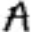

Predicted: L
Actual: A


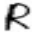

Predicted: L
Actual: R


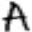

Predicted: L
Actual: A


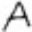

Predicted: L
Actual: A


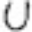

Predicted: L
Actual: U


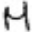

Predicted: L
Actual: M


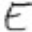

Predicted: L
Actual: E


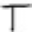

Predicted: L
Actual: T


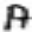

Predicted: L
Actual: A


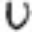

Predicted: E
Actual: U


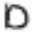

Predicted: L
Actual: D


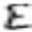

Predicted: L
Actual: E


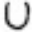

Predicted: L
Actual: M


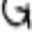

Predicted: E
Actual: U


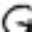

Predicted: L
Actual: G


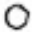

Predicted: L
Actual: O


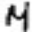

Predicted: L
Actual: M


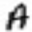

Predicted: L
Actual: A


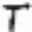

Predicted: L
Actual: T


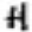

Predicted: L
Actual: H


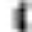

Predicted: L
Actual: I


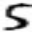

Predicted: L
Actual: S


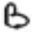

Predicted: L
Actual: B


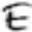

Predicted: L
Actual: E


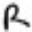

Predicted: L
Actual: R


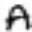

Predicted: L
Actual: A


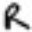

Predicted: L
Actual: R


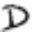

Predicted: E
Actual: D


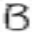

Predicted: L
Actual: B


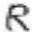

Predicted: L
Actual: R


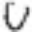

Predicted: L
Actual: U


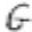

Predicted: L
Actual: G


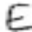

Predicted: L
Actual: E


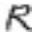

Predicted: L
Actual: R


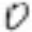

Predicted: L
Actual: O


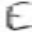

Predicted: L
Actual: E


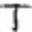

Predicted: L
Actual: T


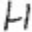

Predicted: L
Actual: H


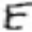

Predicted: L
Actual: E


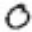

Predicted: L
Actual: O


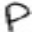

Predicted: E
Actual: P


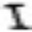

Predicted: L
Actual: I


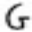

Predicted: L
Actual: G


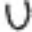

Predicted: L
Actual: U


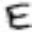

Predicted: L
Actual: E


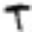

Predicted: L
Actual: T


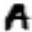

Predicted: L
Actual: A


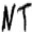

Predicted: L
Actual: N


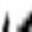

Predicted: L
Actual: T


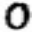

Predicted: E
Actual: O


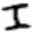

Predicted: L
Actual: I


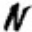

Predicted: L
Actual: N


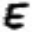

Predicted: L
Actual: E


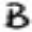

Predicted: E
Actual: B


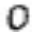

Predicted: E
Actual: O


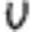

Predicted: E
Actual: U


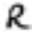

Predicted: L
Actual: R


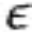

Predicted: L
Actual: E


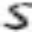

Predicted: L
Actual: S


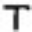

Predicted: L
Actual: T


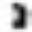

Predicted: L
Actual: I


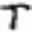

Predicted: L
Actual: T


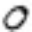

Predicted: L
Actual: O


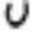

Predicted: E
Actual: U


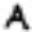

Predicted: L
Actual: A


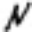

Predicted: L
Actual: N


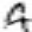

Predicted: L
Actual: H


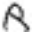

Predicted: L
Actual: A


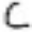

Predicted: L
Actual: R


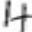

Predicted: L
Actual: C


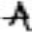

Predicted: L
Actual: H


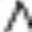

Predicted: L
Actual: A


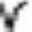

Predicted: L
Actual: N


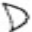

Predicted: L
Actual: D


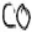

Predicted: L
Actual: C


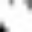

Predicted: L
Actual: O


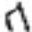

Predicted: L
Actual: R


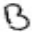

Predicted: L
Actual: B


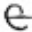

Predicted: L
Actual: E


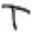

Predicted: L
Actual: T


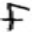

Predicted: E
Actual: F


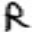

Predicted: L
Actual: R


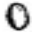

Predicted: E
Actual: O


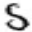

Predicted: L
Actual: S


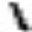

Predicted: L
Actual: I


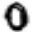

Predicted: E
Actual: O


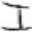

Predicted: L
Actual: I


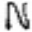

Predicted: L
Actual: N


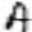

Predicted: L
Actual: A


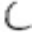

Predicted: L
Actual: C


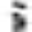

Predicted: L
Actual: I


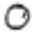

Predicted: L
Actual: O


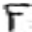

Predicted: L
Actual: F


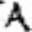

Predicted: L
Actual: A


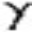

Predicted: L
Actual: Y


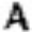

Predicted: L
Actual: A


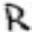

Predicted: L
Actual: R


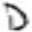

Predicted: E
Actual: D


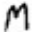

Predicted: L
Actual: M


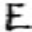

Predicted: L
Actual: E


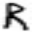

Predicted: L
Actual: R


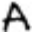

Predicted: L
Actual: A


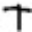

Predicted: L
Actual: T


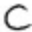

Predicted: L
Actual: C


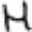

Predicted: L
Actual: H


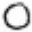

Predicted: L
Actual: O


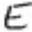

Predicted: L
Actual: E


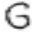

Predicted: L
Actual: G


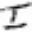

Predicted: L
Actual: I


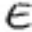

Predicted: L
Actual: E


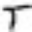

Predicted: L
Actual: T


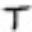

Predicted: L
Actual: T


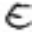

Predicted: L
Actual: E


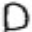

Predicted: L
Actual: D


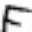

Predicted: L
Actual: E


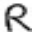

Predicted: L
Actual: R


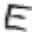

Predicted: L
Actual: E


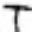

Predicted: L
Actual: T


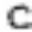

Predicted: L
Actual: C


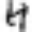

Predicted: L
Actual: H


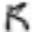

Predicted: L
Actual: R


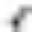

Predicted: L
Actual: I


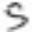

Predicted: L
Actual: S


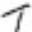

Predicted: L
Actual: T


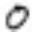

Predicted: L
Actual: O


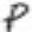

Predicted: L
Actual: P


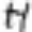

Predicted: L
Actual: H


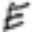

Predicted: L
Actual: E


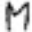

Predicted: L
Actual: M


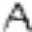

Predicted: L
Actual: A


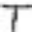

Predicted: L
Actual: T


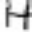

Predicted: L
Actual: H


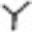

Predicted: L
Actual: Y


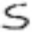

Predicted: L
Actual: S


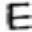

Predicted: L
Actual: E


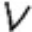

Predicted: E
Actual: V


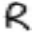

Predicted: L
Actual: R


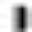

Predicted: L
Actual: I


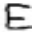

Predicted: L
Actual: E


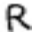

Predicted: L
Actual: R


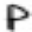

Predicted: L
Actual: P


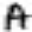

Predicted: L
Actual: A


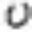

Predicted: L
Actual: U


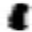

Predicted: L
Actual: I


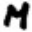

Predicted: L
Actual: M


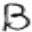

Predicted: L
Actual: B


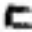

Predicted: L
Actual: E


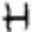

Predicted: L
Actual: H


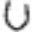

Predicted: L
Actual: U


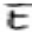

Predicted: L
Actual: E


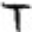

Predicted: L
Actual: T


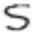

Predicted: L
Actual: S


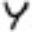

Predicted: L
Actual: Y


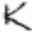

Predicted: L
Actual: K


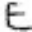

Predicted: L
Actual: E


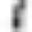

Predicted: L
Actual: I


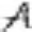

Predicted: L
Actual: A


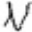

Predicted: L
Actual: N


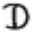

Predicted: L
Actual: D


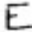

Predicted: L
Actual: E


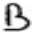

Predicted: L
Actual: B


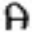

Predicted: L
Actual: A


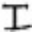

Predicted: L
Actual: I


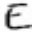

Predicted: L
Actual: E


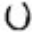

Predicted: L
Actual: U


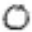

Predicted: L
Actual: O


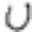

Predicted: L
Actual: U


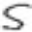

Predicted: L
Actual: S


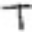

Predicted: L
Actual: T


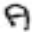

Predicted: L
Actual: A


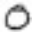

Predicted: L
Actual: O


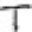

Predicted: L
Actual: T


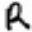

Predicted: L
Actual: R


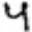

Predicted: L
Actual: Y


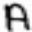

Predicted: L
Actual: A


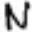

Predicted: L
Actual: N


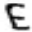

Predicted: L
Actual: E


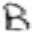

Predicted: L
Actual: B


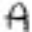

Predicted: L
Actual: A


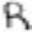

Predicted: L
Actual: R


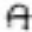

Predicted: L
Actual: A


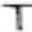

Predicted: L
Actual: T


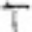

Predicted: L
Actual: T


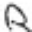

Predicted: L
Actual: R


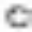

Predicted: L
Actual: I


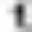

Predicted: L
Actual: S


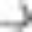

Predicted: L
Actual: T


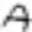

Predicted: L
Actual: A


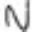

Predicted: L
Actual: N


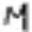

Predicted: L
Actual: M


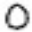

Predicted: L
Actual: O


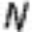

Predicted: L
Actual: N


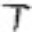

Predicted: L
Actual: T


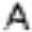

Predicted: L
Actual: A


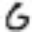

Predicted: L
Actual: G


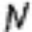

Predicted: L
Actual: N


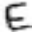

Predicted: L
Actual: E


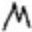

Predicted: L
Actual: M


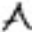

Predicted: L
Actual: A


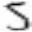

Predicted: L
Actual: S


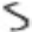

Predicted: L
Actual: S


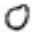

Predicted: L
Actual: O


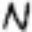

Predicted: L
Actual: N


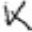

Predicted: L
Actual: K


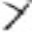

Predicted: L
Actual: Y


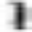

Predicted: L
Actual: I


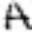

Predicted: L
Actual: A


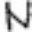

Predicted: L
Actual: N


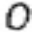

Predicted: L
Actual: O


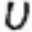

Predicted: E
Actual: U


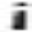

Predicted: L
Actual: I


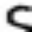

Predicted: L
Actual: S


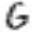

Predicted: E
Actual: G


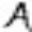

Predicted: L
Actual: A


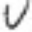

Predicted: L
Actual: U


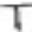

Predicted: L
Actual: T


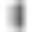

Predicted: L
Actual: I


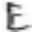

Predicted: L
Actual: E


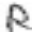

Predicted: L
Actual: R


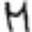

Predicted: L
Actual: M


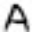

Predicted: L
Actual: A


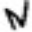

Predicted: L
Actual: N


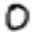

Predicted: E
Actual: O


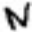

Predicted: L
Actual: N


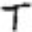

Predicted: L
Actual: T


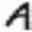

Predicted: L
Actual: A


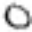

Predicted: L
Actual: O


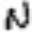

Predicted: L
Actual: N


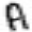

Predicted: E
Actual: A


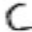

Predicted: L
Actual: C


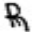

Predicted: L
Actual: R


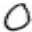

Predicted: L
Actual: O


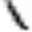

Predicted: L
Actual: I


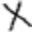

Predicted: L
Actual: X


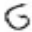

Predicted: L
Actual: G


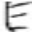

Predicted: L
Actual: E


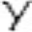

Predicted: L
Actual: Y


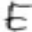

Predicted: L
Actual: E


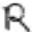

Predicted: L
Actual: R


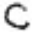

Predicted: L
Actual: C


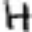

Predicted: L
Actual: H


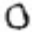

Predicted: L
Actual: O


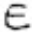

Predicted: L
Actual: E


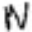

Predicted: L
Actual: N


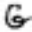

Predicted: L
Actual: G


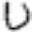

Predicted: L
Actual: U


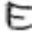

Predicted: L
Actual: E


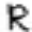

Predicted: L
Actual: R


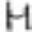

Predicted: L
Actual: M


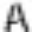

Predicted: L
Actual: A


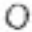

Predicted: L
Actual: O


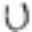

Predicted: L
Actual: U


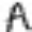

Predicted: L
Actual: A


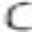

Predicted: L
Actual: C


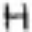

Predicted: L
Actual: H


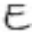

Predicted: L
Actual: E


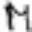

Predicted: L
Actual: M


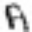

Predicted: L
Actual: A


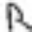

Predicted: L
Actual: R


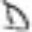

Predicted: L
Actual: D


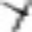

Predicted: L
Actual: Y


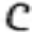

Predicted: L
Actual: C


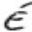

Predicted: L
Actual: E


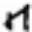

Predicted: L
Actual: M


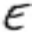

Predicted: L
Actual: E


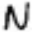

Predicted: L
Actual: N


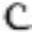

Predicted: L
Actual: C


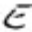

Predicted: L
Actual: E


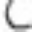

Predicted: L
Actual: C


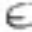

Predicted: L
Actual: E


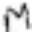

Predicted: L
Actual: M


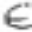

Predicted: L
Actual: E


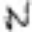

Predicted: L
Actual: N


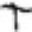

Predicted: L
Actual: T


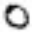

Predicted: L
Actual: O


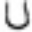

Predicted: L
Actual: U


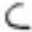

Predicted: L
Actual: C


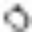

Predicted: L
Actual: I


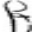

Predicted: L
Actual: B


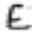

Predicted: L
Actual: E


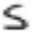

Predicted: L
Actual: S


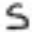

Predicted: L
Actual: S


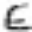

Predicted: L
Actual: E


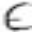

Predicted: L
Actual: E


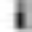

Predicted: L
Actual: I


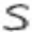

Predicted: L
Actual: S


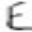

Predicted: L
Actual: E


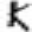

Predicted: L
Actual: K


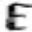

Predicted: L
Actual: E


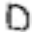

Predicted: L
Actual: D


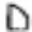

Predicted: L
Actual: D


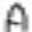

Predicted: L
Actual: A


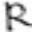

Predicted: L
Actual: R


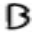

Predicted: E
Actual: B


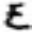

Predicted: L
Actual: E


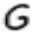

Predicted: L
Actual: G


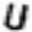

Predicted: E
Actual: U


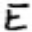

Predicted: L
Actual: E


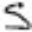

Predicted: L
Actual: S


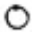

Predicted: L
Actual: O


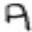

Predicted: L
Actual: A


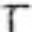

Predicted: E
Actual: T


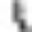

Predicted: L
Actual: I


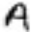

Predicted: L
Actual: A


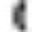

Predicted: L
Actual: B


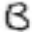

Predicted: L
Actual: I


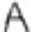

Predicted: L
Actual: A


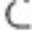

Predicted: L
Actual: C


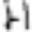

Predicted: L
Actual: H


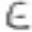

Predicted: L
Actual: E


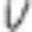

Predicted: L
Actual: V


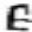

Predicted: L
Actual: E


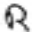

Predicted: L
Actual: R


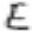

Predicted: L
Actual: E


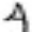

Predicted: L
Actual: A


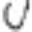

Predicted: L
Actual: U


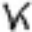

Predicted: L
Actual: K


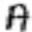

Predicted: L
Actual: A


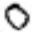

Predicted: L
Actual: O


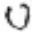

Predicted: L
Actual: U


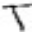

Predicted: L
Actual: T


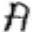

Predicted: L
Actual: A


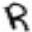

Predicted: E
Actual: R


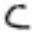

Predicted: L
Actual: C


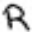

Predicted: L
Actual: R


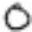

Predicted: L
Actual: O


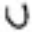

Predicted: E
Actual: U


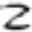

Predicted: L
Actual: Z


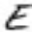

Predicted: L
Actual: E


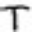

Predicted: L
Actual: T


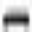

Predicted: L
Actual: -


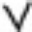

Predicted: L
Actual: V


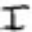

Predicted: L
Actual: I


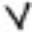

Predicted: L
Actual: V


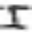

Predicted: L
Actual: I


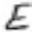

Predicted: L
Actual: E


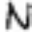

Predicted: L
Actual: N


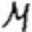

Predicted: L
Actual: M


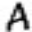

Predicted: L
Actual: A


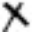

Predicted: L
Actual: X


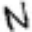

Predicted: L
Actual: N


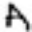

Predicted: L
Actual: A


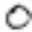

Predicted: L
Actual: O


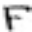

Predicted: L
Actual: F


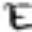

Predicted: L
Actual: E


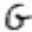

Predicted: L
Actual: N


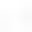

Predicted: L
Actual: G


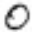

Predicted: L
Actual: O


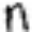

Predicted: L
Actual: N


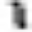

Predicted: L
Actual: D


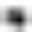

Predicted: L
Actual: I


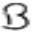

Predicted: L
Actual: B


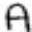

Predicted: L
Actual: A


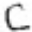

Predicted: L
Actual: C


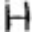

Predicted: L
Actual: H


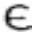

Predicted: L
Actual: E


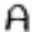

Predicted: L
Actual: A


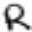

Predicted: L
Actual: R


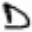

Predicted: L
Actual: D


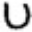

Predicted: L
Actual: U


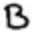

Predicted: E
Actual: B


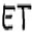

Predicted: L
Actual: E


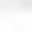

Predicted: L
Actual: T


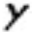

Predicted: L
Actual: Y


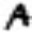

Predicted: L
Actual: A


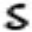

Predicted: L
Actual: S


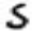

Predicted: L
Actual: S


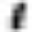

Predicted: L
Actual: I


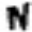

Predicted: L
Actual: N


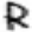

Predicted: E
Actual: R


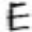

Predicted: L
Actual: E


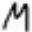

Predicted: L
Actual: M


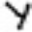

Predicted: L
Actual: Y


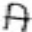

Predicted: L
Actual: A


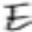

Predicted: L
Actual: E


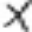

Predicted: L
Actual: X


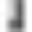

Predicted: L
Actual: I


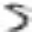

Predicted: L
Actual: S


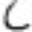

Predicted: L
Actual: C


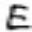

Predicted: L
Actual: E


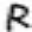

Predicted: L
Actual: R


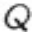

Predicted: L
Actual: Q


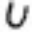

Predicted: E
Actual: U


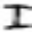

Predicted: L
Actual: I


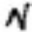

Predicted: L
Actual: N


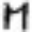

Predicted: L
Actual: M


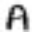

Predicted: L
Actual: A


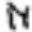

Predicted: E
Actual: N


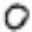

Predicted: L
Actual: O


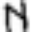

Predicted: L
Actual: N


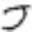

Predicted: L
Actual: J


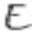

Predicted: L
Actual: E


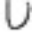

Predicted: L
Actual: U


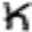

Predicted: L
Actual: K


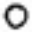

Predicted: E
Actual: O


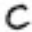

Predicted: E
Actual: C


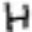

Predicted: L
Actual: H


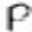

Predicted: L
Actual: P


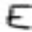

Predicted: L
Actual: E


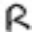

Predicted: L
Actual: R


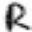

Predicted: L
Actual: R


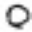

Predicted: E
Actual: O


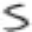

Predicted: L
Actual: S


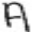

Predicted: L
Actual: A


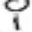

Predicted: L
Actual: I


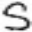

Predicted: L
Actual: S


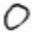

Predicted: L
Actual: O


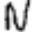

Predicted: L
Actual: N


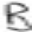

Predicted: L
Actual: B


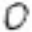

Predicted: L
Actual: O


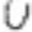

Predicted: L
Actual: U


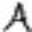

Predicted: L
Actual: A


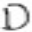

Predicted: L
Actual: D


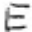

Predicted: L
Actual: E


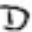

Predicted: L
Actual: D


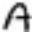

Predicted: L
Actual: A


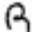

Predicted: L
Actual: R


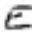

Predicted: L
Actual: E


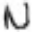

Predicted: L
Actual: N


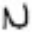

Predicted: L
Actual: N


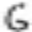

Predicted: L
Actual: G


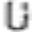

Predicted: L
Actual: U


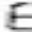

Predicted: L
Actual: E


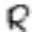

Predicted: L
Actual: R


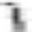

Predicted: L
Actual: I


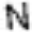

Predicted: L
Actual: N


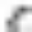

Predicted: L
Actual: S


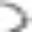

Predicted: L
Actual: E


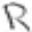

Predicted: E
Actual: R


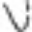

Predicted: L
Actual: V


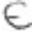

Predicted: L
Actual: E


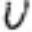

Predicted: L
Actual: U


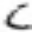

Predicted: L
Actual: C


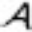

Predicted: L
Actual: A


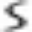

Predicted: L
Actual: S


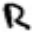

Predicted: L
Actual: R


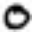

Predicted: L
Actual: O


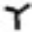

Predicted: L
Actual: Y


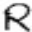

Predicted: L
Actual: R


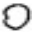

Predicted: L
Actual: O


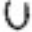

Predicted: L
Actual: U


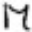

Predicted: L
Actual: M


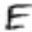

Predicted: L
Actual: E


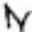

Predicted: L
Actual: N


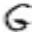

Predicted: L
Actual: G


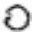

Predicted: L
Actual: O


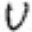

Predicted: L
Actual: U


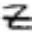

Predicted: L
Actual: Z


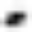

Predicted: L
Actual: I


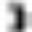

Predicted: L
Actual: E


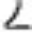

Predicted: L
Actual: E


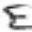

Predicted: L
Actual: N


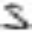

Predicted: L
Actual: S


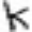

Predicted: L
Actual: K


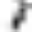

Predicted: L
Actual: I


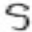

Predicted: L
Actual: S


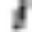

Predicted: L
Actual: I


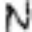

Predicted: L
Actual: N


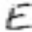

Predicted: L
Actual: E


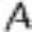

Predicted: L
Actual: A


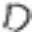

Predicted: L
Actual: D


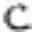

Predicted: L
Actual: C


In [ ]:
predicted_y = model.predict(resized_letters)
max_indices = tf.argmax(predicted_y, axis = 1)
for i in range(1000,1500):
  if alphabet[np.asarray(max_indices)[i]] != characters_obtained2[i]:
    cv2_imshow(X_train[i])
    print("Predicted: "+str(alphabet[np.asarray(max_indices)[i]]))
    print("Actual: "+str(characters_obtained2[i]))
#for idx in max_indices:
  #print(alphabet[idx])

In [ ]:
model.score(train_X,train_y)

AttributeError: ignored

Random forest

In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
def get_data_subset(data_X, data_Y, number_train_obs):
    train_X, train_y, test_X, test_y = data_X[:number_train_obs], data_Y[:number_train_obs], data_X[number_train_obs + 1:], data_Y[number_train_obs + 1:]
    return np.array(train_X), np.array(train_y), np.array(test_X), np.array(test_y)

In [ ]:
#train_X, train_y, test_X, test_y = get_data_subset(letters_obtained2, characters_obtained2, 400)
train_X, train_y, test_X, test_y = get_data_subset(resized_letters, np.asarray(one_hot_list), 400)

In [ ]:
train_X[0].shape

(32, 32)

In [ ]:
#train_X, train_y, test_X, test_y = flatten_letters(train_X), flatten_letters(train_y), flatten_letters(text_X), flatten_letters(test_y)
train_X, test_X = flatten_letters(train_X), flatten_letters(test_X)

In [ ]:
train_acc_mean, train_acc_std = [], [] # to store the training accuracies
test_acc_mean, test_acc_std = [], []   # to store the testing accuracies

for d in tqdm(range(1, 16), initial=1): # loop over tree depths
    train_perfs = [] # store interem train scores
    test_perfs = []  # store interem test scores
    for n in range(10):   # loop over random initializations
        decisionTree = tree.DecisionTreeClassifier(max_depth= d)
        decisionTree = decisionTree.fit(train_X, train_y)
        train_perfs.append(decisionTree.score(train_X, train_y))
        test_perfs.append(decisionTree.score(test_X, test_y))

    # append mean and std scores to appropriate lists
    train_acc_mean.append(np.mean(train_perfs))
    train_acc_std.append(np.std(train_perfs))
    test_acc_mean.append(np.mean(test_perfs))
    test_acc_std.append(np.std(test_perfs))

16it [01:14,  4.98s/it]


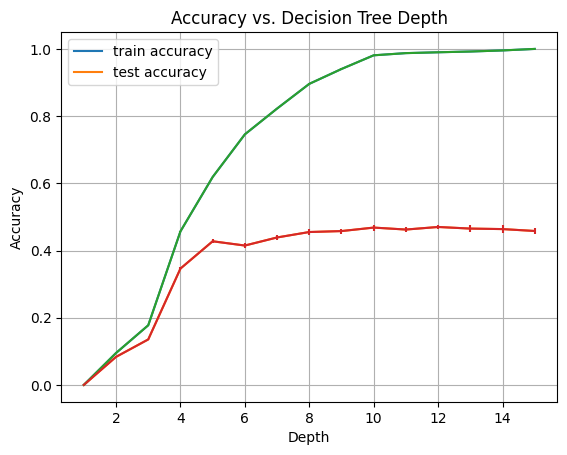

In [ ]:
plt.plot(list(range(1, 16)), train_acc_mean, label="train accuracy")
plt.plot(list(range(1, 16)), test_acc_mean, label="test accuracy")
plt.errorbar(list(range(1, 16)), train_acc_mean, yerr=train_acc_std)
plt.errorbar(list(range(1, 16)), test_acc_mean, yerr=test_acc_std)
plt.title("Accuracy vs. Decision Tree Depth")
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Depth")
plt.grid()
plt.show()

In [ ]:
train_acc_mean, train_acc_std = np.zeros((10, 8)), np.zeros((10, 8)) # storing it in an np array instead of a list makes it easier
test_acc_mean, test_acc_std = np.zeros((10, 8)), np.zeros((10, 8))

n_trees = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
depths = [1, 3, 5, 7, 9, 11, 13, 15]

for tree_idx, number in enumerate(n_trees):
    for d_idx, d in enumerate(depths):
        train_perfs = []
        test_perfs = []
        for n in range(5):
            # init new model
            randomForest = RFC(number, max_depth= d)
            # train model
            randomForest = randomForest.fit(train_X, train_y)
            # store interem values
            train_perfs.append(randomForest.score(train_X, train_y))
            test_perfs.append(randomForest.score(test_X, test_y))
        train_acc_mean[tree_idx][d_idx] = np.mean(train_perfs)
        train_acc_std[tree_idx][d_idx] = np.std(train_perfs)
        test_acc_mean[tree_idx][d_idx] = np.mean(test_perfs)
        test_acc_std[tree_idx][d_idx] = np.std(test_perfs)

In [ ]:
# Figure 1
plt.figure()
sns.heatmap(data=train_acc_mean, annot=True, xticklabels=depths, yticklabels=n_trees) # create seaborn heatmap with annotations, xticklabels and yticklabels
# add a title
plt.title("Number of Trees & Decision Tree Depth vs. Train Accuracy")
# add axis labels
plt.ylabel("# of trees")
plt.xlabel("Depth")
plt.show()

# Figure 2
plt.figure()
sns.heatmap(data=test_acc_mean, annot=True, xticklabels=depths, yticklabels=n_trees) # create seaborn heatmap with annotations, xticklabels and yticklabels
# add a title
plt.title("Number of Trees & Decision Tree Depth vs. Test Accuracy")
# add axis labels
plt.ylabel("# of trees")
plt.xlabel("Depth")
plt.show()